In [401]:
# Install the requirements.txt file

# Do Git commands in BASH not POWERSHELL

In [402]:
# Import base packages
import os
import pandas as pd
import numpy as np

#### Data Identification

In [403]:
# Identify the files and import the data
folder_path = "./Data/NLP Disaster Tweets/"
files = os.listdir(folder_path)

print(files) # Train, Test, and a sample for submission

['sample_submission.csv', 'test.csv', 'train.csv']


In [404]:
# Open the 'train.csv'
train_csv = pd.read_csv(folder_path+files[-1])
train_csv.sample(5)

,id,keyword,location,text,target
5974,8530,screaming,NaN,@danisnotonfire if you follow me I will go int...,0
1684,2429,collide,EspÌ_rito Santo,Maybe if the stars align maybe if our worlds c...,0
6243,8916,snowstorm,This Is Paradise. Relax.,ÛÏ@LordBrathwaite: Everyone Here: Ahh I hate ...,1
5935,8476,screamed,1D | 5SOS | AG,I JUST SCREAMED IN 57 LANGUAGES THIS IS SO GOO...,0
384,556,arson,Our Empire State,Another fake hate crime Lesbians burn their ow...,1


In [405]:
# Test too
test_csv = pd.read_csv(folder_path+files[1])

In [406]:
# We'll want to get a good measure on the amount of "NaN"'s present
train_csv.isna().sum() 

# Most NaN's are located within the 'location' section, probably meaning no location
# was tagged in the tweet.
# We are missing some keywords though, thankfully just a small amount

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [407]:
# Let's look closer at the NaN keyword tweets, could be a pattern of some kind
nan_keyword_txts =  train_csv[train_csv["keyword"].isna()]

# All missing keyword texts are also missing their locations
nan_keyword_txts.isna().sum()

id           0
keyword     61
location    61
text         0
target       0
dtype: int64

In [408]:
# Check types
train_csv.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

#### Text Cleaning & Pre-processing

In [409]:
# Start with the original dataset, I need to do a few things:
# 1) Get a count of keywords and see what's common
# 2) Clean the 'text' column of unecessary characters, I'll do this in a function so I can apply the
#    other df to it as well
# 3) Tokenize the clean text and start to look for patterns within both
# 4) Since this is a classification model, I'll need some way of classifying the text, I may just use a 
#    random forrest or a K-means here... worry about later.

In [410]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt

In [411]:
# One thing for sure is that several keywords have a "%20" where a space would be, I'll have to clean up the text and such first 
# before I move any further...

# To clean up the keywords, locations, and text, I can create a function to do so or make use of pandas calls
# If I plan to employ this on my website, I may need a function running to allow for user inputs to be cleaned
# before they get tested by the model

In [412]:
# Sample tweets
train_csv["text"].sample(3)

3053    M1.57 [01:11 UTC]?3km NNW of Lake Henshaw Cali...
2210    China is only delaying the deluge: If the fund...
1535    Sign the petition @david_cameron to protect be...
Name: text, dtype: object

In [413]:
# Sample locations
train_csv["location"].sample(3)

4799                Kenya
5864                  NaN
2527    Prehistoric Earth
Name: location, dtype: object

In [414]:
# Sample keywords
train_csv["keyword"].sample(3)

5999      screams
5577    rainstorm
6857       trauma
Name: keyword, dtype: object

In [415]:
# For cleaning up the keyword
def keyCleaner(key):    
    try:
        # Strip unwanted text
        key = key.replace("%20", " ")

        # all lowercase
        key = key.lower()
        return key
    except AttributeError:
        pass

# Next the text portion (the actual tweet)
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def removePunct(text):
    # I want to remove all punct for the sake of vectorization later
    pattern = r"[!@#$%^&*()_+=\[\]{};\'\\:|<,./?><]"
    
    text_without_punctuation = re.sub(pattern, '', text)
    return text_without_punctuation

def lowerCase(text):
    text = text.lower()
    return text

In [416]:
# Apply the function of the keywords column
train_csv["keyword"] = train_csv["keyword"].apply(lambda key: keyCleaner(key))

# Apply the other functions to the text for both train & test
lst = [train_csv, test_csv]
for df in lst:
    df["text"] = df["text"].apply(lambda text: remove_URL(text))
    df["text"] = df["text"].apply(lambda text: remove_html(text))
    df["text"] = df["text"].apply(lambda text: remove_emoji(text))
    df["text"] = df["text"].apply(lambda text: lowerCase(text))
    df["text"] = df["text"].apply(lambda text: removePunct(text))

# Tailor the function to be able to process locatioon and the tweet itself
# Maybe something can be done with the location that can be aimed at helping taylor the classification?

In [417]:
# Collects the words for the WordCloud
def create_corpus(tweet, target):
    # For the non-target ones too
    events = []

    # Gather target word for a disaster
    for x in tweet[tweet['target'] == target]['text'].str.split():
        for i in x:
            events.append(i)
    return events

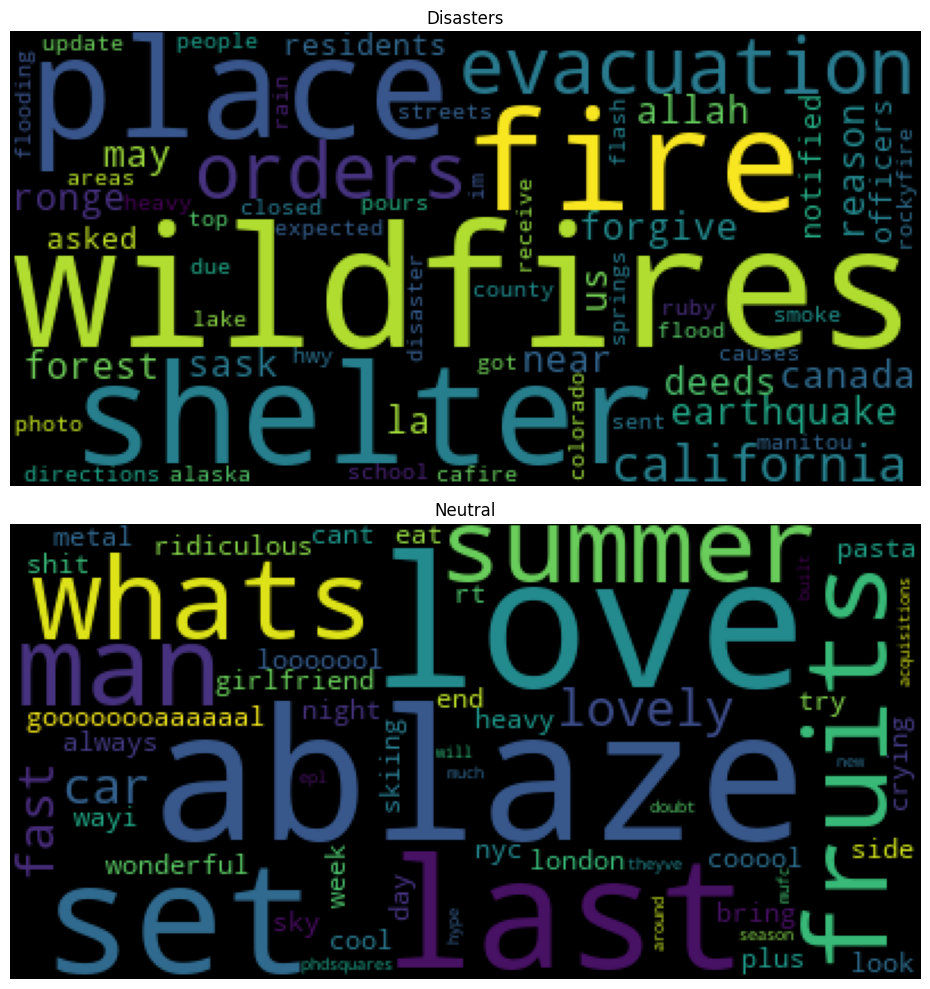

In [418]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Create a wordcloud of the tweet targets from the "train_csv"
disaster = create_corpus(train_csv, 1)
neutral = create_corpus(train_csv, 0)

word_cloud_disaster = WordCloud(max_font_size=80).generate(" ".join(disaster[:100]))
word_cloud_neutral = WordCloud(max_font_size=80).generate(" ".join(neutral[:100]))

ax[0].imshow(word_cloud_disaster)
ax[0].axis('off')
ax[0].set_title("Disasters")

ax[1].imshow(word_cloud_neutral)
ax[1].axis('off');
ax[1].set_title("Neutral")
plt.tight_layout()

In [419]:
# Looks like the "Disasters" have more negative-themed words, that we can use to our advantage

#### Sentiment Analysis - VADER Methodology

In [420]:
# Before I go any further, I want to consider sentiment analysis as another column that
# could help the classification model make a better suggestion...

# Several different types exist, one I may consider for this since it's social media is
# VADER - Valence Aware Dictionary and sEntiment Reasoner

# The thought for me here is to get information based on the positivity, negativity, or neutrality
# of the text. I can use those values as a way to train the model for assessment later.

In [421]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a function that presses each text against VADER and create a column using the outputs

# Create the object
sid_obj = SentimentIntensityAnalyzer()
def vader(text):
    # Read the text into the analyzer
    vader_dict = sid_obj.polarity_scores(text)

    # Return the dict (values can be accessed)
    return vader_dict

In [422]:
# If we wanted to try a different analysis, copy the df
train_csv_VADER, test_csv_VADER = train_csv.copy(), test_csv.copy()

# Apply the function to the dataset
sent_lst = [train_csv_VADER, test_csv_VADER]
for df in sent_lst:
    df["negative"] = df["text"].apply(lambda t: vader(t)["neg"])
    df["neutral"] = df["text"].apply(lambda t: vader(t)["neu"])
    df["positive"] = df["text"].apply(lambda t: vader(t)["pos"])

    # Final "combination" section
    df["compound"] = df["text"].apply(lambda t: vader(t)["compound"])

In [423]:
# Dictionaries for storing the count of either 0 or 1 for each sentiment category - Just training

pos_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["positive"] >= 0.3].groupby("target").count()["positive"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["positive"] >= 0.3].groupby("target").count()["positive"][0]}

neg_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["negative"] >= 0.3].groupby("target").count()["negative"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["negative"] >= 0.3].groupby("target").count()["negative"][0]}

neut_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["neutral"] >= 0.3].groupby("target").count()["neutral"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["neutral"] >= 0.3].groupby("target").count()["neutral"][0]}

combined_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["compound"] >= 0.3].groupby("target").count()["compound"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["compound"] >= 0.3].groupby("target").count()["compound"][0]}

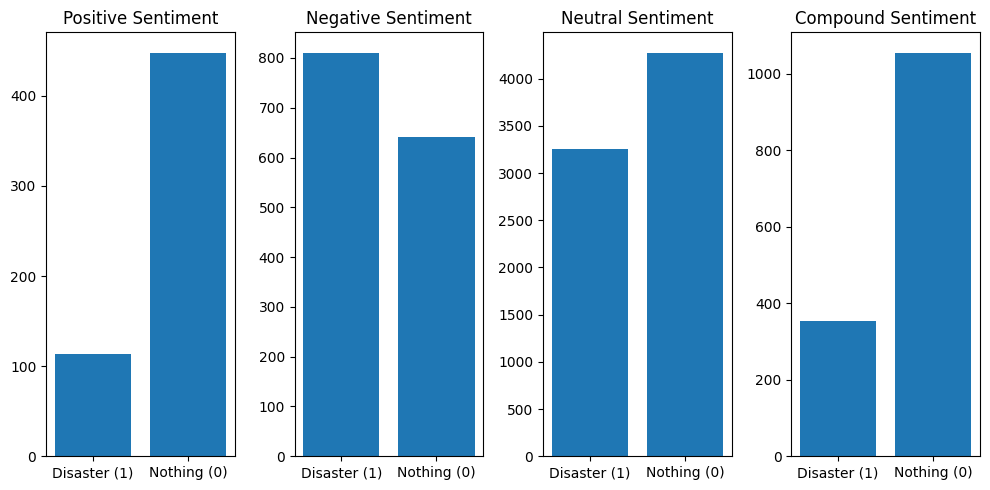

In [424]:
# Lets assess some of the values
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))

# Create four graphs (+, -, =, //) that depict the VADER analysis against the target count
ax[0].bar(pos_dict.keys(), pos_dict.values())
ax[0].set_title("Positive Sentiment")

ax[1].bar(neg_dict.keys(), neg_dict.values())
ax[1].set_title("Negative Sentiment")

ax[2].bar(neut_dict.keys(), neut_dict.values())
ax[2].set_title("Neutral Sentiment")

ax[3].bar(combined_dict.keys(), combined_dict.values())
ax[3].set_title("Compound Sentiment")

plt.tight_layout()

In [425]:
# Tells me that the sentiment analysis is better at detecting the positives (0) than the negatives
# I'd only want to include that "statement positivity" value in the model.

# The 'compound' sentiment leans more positively if the % is over 30%, telling me that although some tweets have
# negativity in them, they have a more positive sentiment. For the sake of modeling, the 'compound' score may help us get the
# best results.

# Remember the goal here is to train a classification model to be capable of descerning this on it's own, I want
# to avoid putting too much info into the model to where overfitting becomes and issue but enough to where
# the model isn't stagnating at a poor accuracy value...

#### Data Splitting

In [426]:
from sklearn.model_selection import train_test_split

In [427]:
# Prior to vectorizing, lets split the data (X and Y)

# I want to bring over the 'positive' from the Sentiment analysis
X = train_csv_VADER[["text", "positive"]]
y = train_csv_VADER["target"]

# Testing text
X_test = test_csv_VADER[["text"]]

# Split the data using a 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### TF-IDF Vectorization

In [428]:
# Work on tokenizing the tweets
from sklearn.feature_extraction.text import TfidfVectorizer

In [429]:
# I'll be using TF-IDF vectorizer because this focuses on the combination of frequency as well
# as rarity of words
tfidf = TfidfVectorizer()
train_tfidf_vectors = tfidf.fit_transform(X_train["text"])
val_tfidf_vectors = tfidf.transform(X_val["text"])

In [430]:
# Vectorize test with the trained tfidf
test_tfidf_vectors = tfidf.transform(X_test["text"])

##### Modeling

In [431]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# I'd want to do a few models here to assess overall accuracies
# Logistic regression wouldn't be bad here because of the way it classifies, it's either >0.5 or <0.5
# I also want to use a Random Forest for the sake of their applicability to classification

##### -- Logistic Regression --

In [432]:
# From Kaggle -- JY: NLP with Disaster Tweets (Top 15%)
def displayConfusionMatrix(y_true, y_pred, dataset):
    try:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            np.argmax(y_pred, axis=1),
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues
        )
        tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    except Exception as e:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues
        )
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(3)))

In [433]:
from sklearn.linear_model import LogisticRegression

# Instantiate the model
logit_model = LogisticRegression()

# Fit with the vectorized training set
logit_model.fit(train_tfidf_vectors, y_train)

LogisticRegression()

In [434]:
# Get score on train
print(f"Training Score: {logit_model.score(train_tfidf_vectors, y_train)}")

# Score on val
print(f"Validation Score: {logit_model.score(val_tfidf_vectors, y_val)}")

Training Score: 0.8901477832512316
Validation Score: 0.8063033486539725


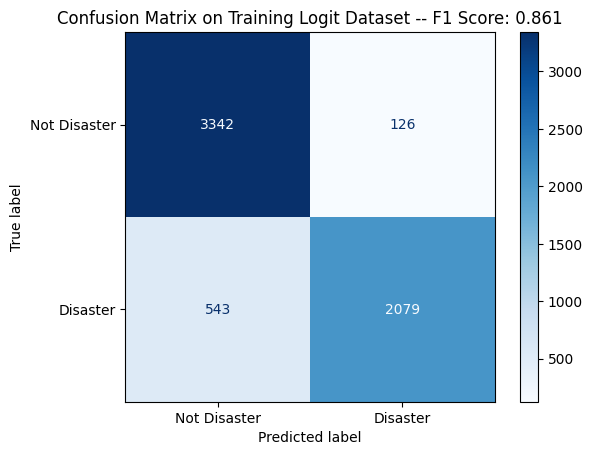

In [435]:
# Confusion matricies
y_pred_train_lr = logit_model.predict(train_tfidf_vectors)

displayConfusionMatrix(y_train, y_pred_train_lr, "Training Logit")

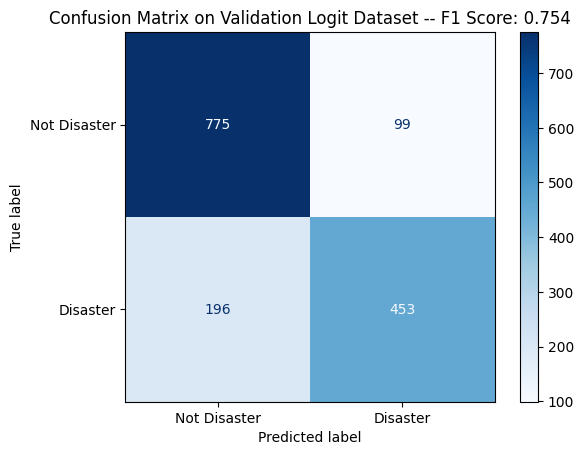

In [436]:
y_pred_val_lr = logit_model.predict(val_tfidf_vectors)

displayConfusionMatrix(y_val, y_pred_val_lr, "Validation Logit")

In [437]:
# The Logistic Regression model is not overfitting but we can make the case it's
# actually UNDERfitting the data. Could be the type of vectorization chosen and how it's reacting
# with the data

##### -- Random Forests --

In [438]:
from sklearn.ensemble import RandomForestClassifier

In [439]:
# I'll be using RF as well due to the nature of the decision tree layout
# Plenty of other models could have been chosen but I chose to use RF for the simplicity sake...

In [440]:
# Instantiate
rf_model = RandomForestClassifier()

# Fit on the data -- Takes a bit more time than the logistic regression one
rf_model.fit(train_tfidf_vectors, y_train)

RandomForestClassifier()

In [441]:
# Get score on train
print(f"Training Score: {rf_model.score(train_tfidf_vectors, y_train)}")

# Score on val
print(f"Validation Score: {rf_model.score(val_tfidf_vectors, y_val)}")

Training Score: 0.9891625615763546
Validation Score: 0.7892317793827971


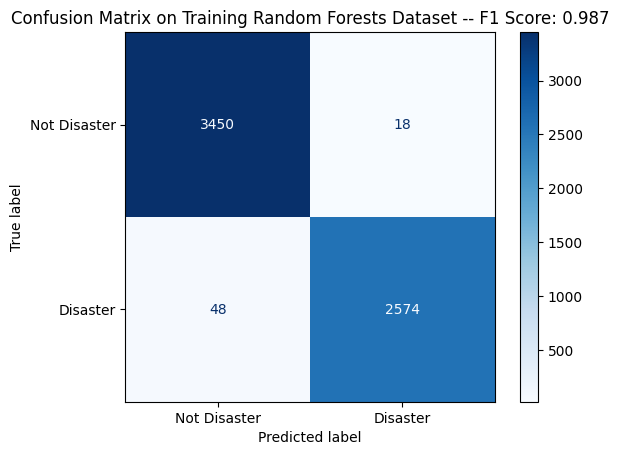

In [442]:
# Confusion matricies
y_pred_train_rf = rf_model.predict(train_tfidf_vectors)

displayConfusionMatrix(y_train, y_pred_train_rf, "Training Random Forests")

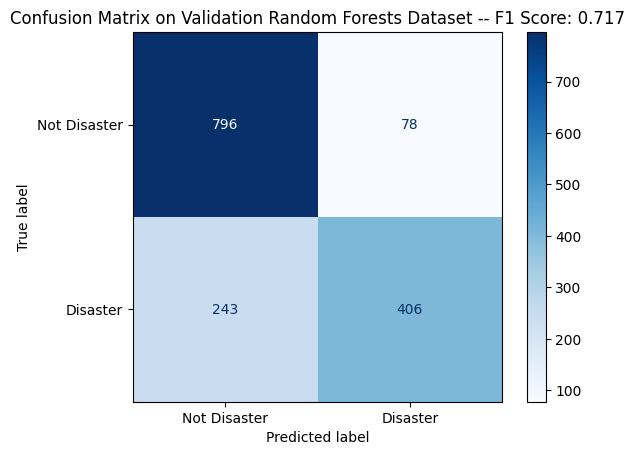

In [443]:
y_pred_val_rf = rf_model.predict(val_tfidf_vectors)

displayConfusionMatrix(y_val, y_pred_val_rf, "Validation Random Forests")

In [444]:
# I think it's fair to say here the RF model is overfitting the data
# The training is very high, nearing 99% accuracy while the validation is pretty poor at 71%

#### Count Vectorization 

In [445]:
# I tried initally with TF-IDF vectorization but the result wasn't what I hoped.
# Part of the issue I believe is due to how the words are being weighted and as we saw
# earlier with sentiment analysis and keywords from the text, negative sentences don't
# seem all that negative. So when we break the words up, those negative words aren't
# getting the model to think it's a disaster enough. Let's try changing the vectorization method.

In [446]:
# Count vectorization just looks at word frequency so rather than taking into account the weight of such word,
# we can rely on the amount of times it's being used. If we look at the word "fire", if it's called several times
# in mainly natural disaster texts, that will standout when combining that info with other words, essentially
# we'd be building a pattern within each tweet that'll help it stand out as positive or negative

In [447]:
from sklearn.feature_extraction.text import CountVectorizer

In [448]:
# Instantiate
count_vect = CountVectorizer()

# Fit/Transform against the data since we want a matrix in return for using later on the test
# The ONLY data that should be fitting on the vectorizer is the main training data, everything else will
# be relying off the fitted vectorizer...
train_count_vect = count_vect.fit_transform(X_train["text"])
val_count_vect = count_vect.transform(X_val["text"])

# Vectorize test with the trained count vector
test_count_vect = count_vect.transform(X_test["text"])

##### -- Logistic Regression --

In [449]:
# Just like from before, Instantiate the model
logit_model = LogisticRegression()

# Fit with the vectorized training set
logit_model.fit(train_count_vect, y_train)

LogisticRegression()

In [450]:
# Get score on train
print(f"Training Score: {logit_model.score(train_count_vect, y_train)}")

# Score on val
print(f"Validation Score: {logit_model.score(val_count_vect, y_val)}")

Training Score: 0.9668308702791462
Validation Score: 0.8049901510177282


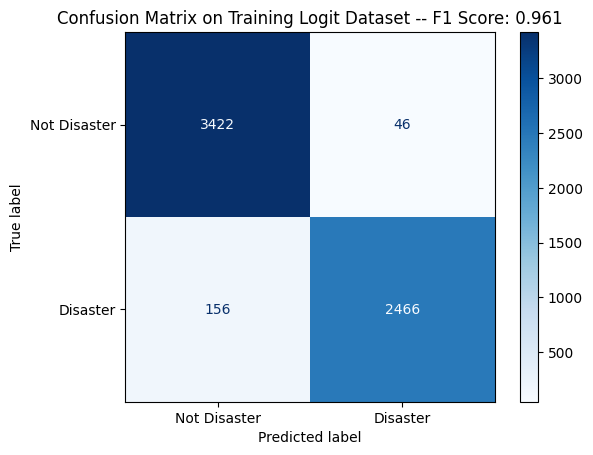

In [451]:
# Confusion matricies
y_pred_train_lr_cnt = logit_model.predict(train_count_vect)

displayConfusionMatrix(y_train, y_pred_train_lr_cnt, "Training Logit")

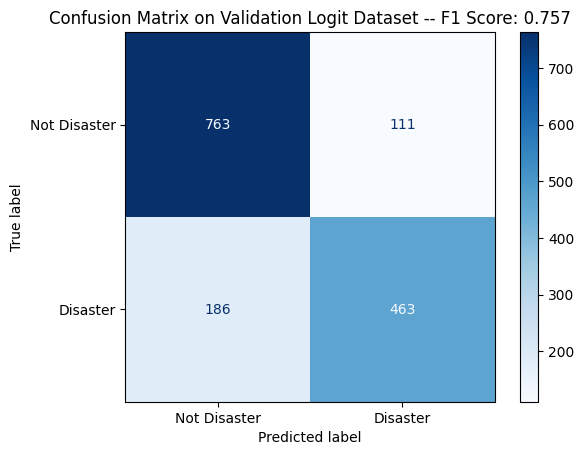

In [452]:
y_pred_val_lr_cnt = logit_model.predict(val_count_vect)

displayConfusionMatrix(y_val, y_pred_val_lr_cnt, "Validation Logit")

In [453]:
# Looking at the results, since I removed some punctuation from the text, that could be interfering with the accuracy
# of the model. That's something I'll have to give a try in another notebook, how the model responds to NOT having any 
# data cleaning.

##### -- Random Forests --

In [454]:
# Instantiate
rf_model = RandomForestClassifier()

# Fit on the data -- Takes a bit more time than the logistic regression one
rf_model.fit(train_count_vect, y_train)

RandomForestClassifier()

In [455]:
# Get score on train
print(f"Training Score: {rf_model.score(train_count_vect, y_train)}")

# Score on val
print(f"Validation Score: {rf_model.score(val_count_vect, y_val)}")

Training Score: 0.9891625615763546
Validation Score: 0.7879185817465528


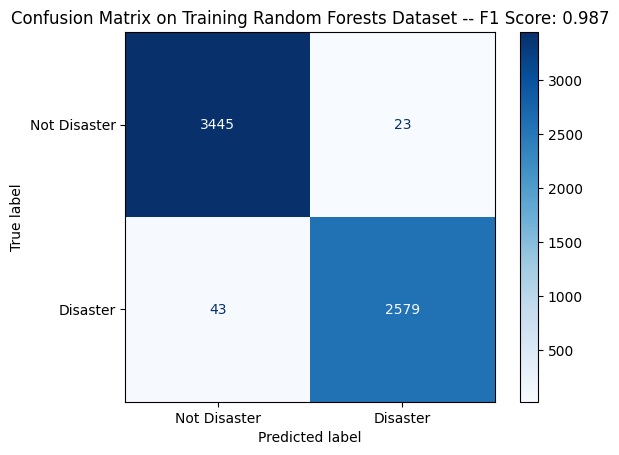

In [456]:
# Confusion matricies
y_pred_train_rf_cnt = rf_model.predict(train_count_vect)

displayConfusionMatrix(y_train, y_pred_train_rf_cnt, "Training Random Forests")

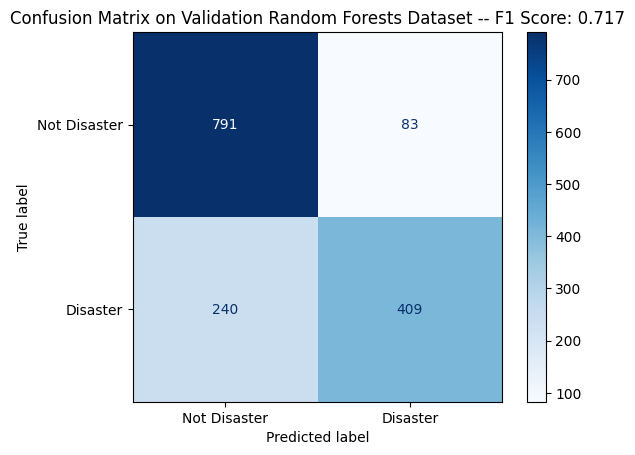

In [457]:
y_pred_val_rf_cnt = rf_model.predict(val_count_vect)

displayConfusionMatrix(y_val, y_pred_val_rf_cnt, "Validation Random Forests")

In [458]:
# The RF model improves slightly (by ~2% on F1) by going from TF-IDF to CountVect. My assumption here is that
# since RF is a decision-tree style model, it's vectors don't have weights here that weight down the braches. In 
# the TF-IDF, the weighting of the words I think interfered with the frequency of specific words and patterns. If we look
# at the TF-IDF for the Logit model, we can similarily say the same, although that one uses the sigmoidal function
# to assess the classification...

#### Results & Compare

In [459]:
# I'll create a few grids of graphs to show side-by-side the results from each vectorizer and model

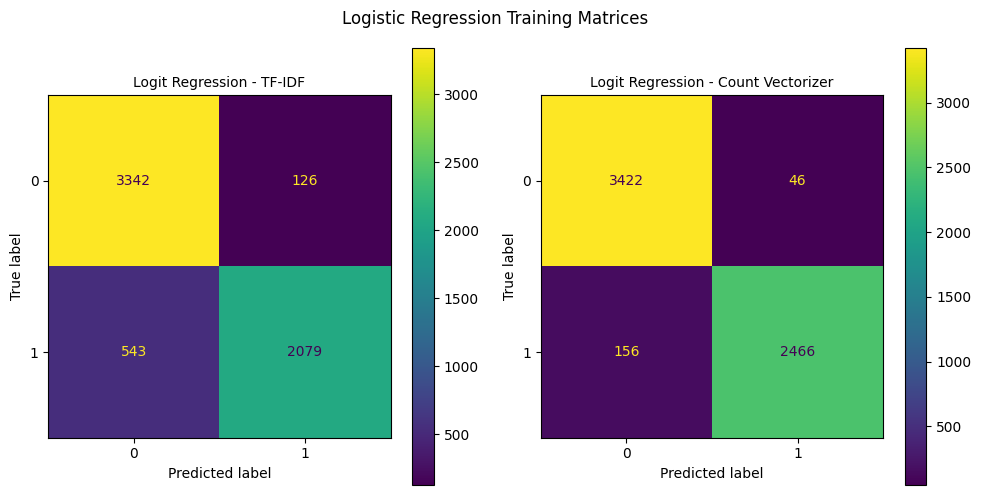

In [460]:
# Lets assess some of the values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Logistic Regression - TF-IDF & Count - TRAINING
ax[0].set_title("Logit Regression - TF-IDF", size=10)
cm = confusion_matrix(y_train, y_pred_train_lr)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[0])

ax[1].set_title("Logit Regression - Count Vectorizer", size=10)
cm = confusion_matrix(y_train, y_pred_train_lr_cnt)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[1])

fig.suptitle("Logistic Regression Training Matrices")

plt.tight_layout()

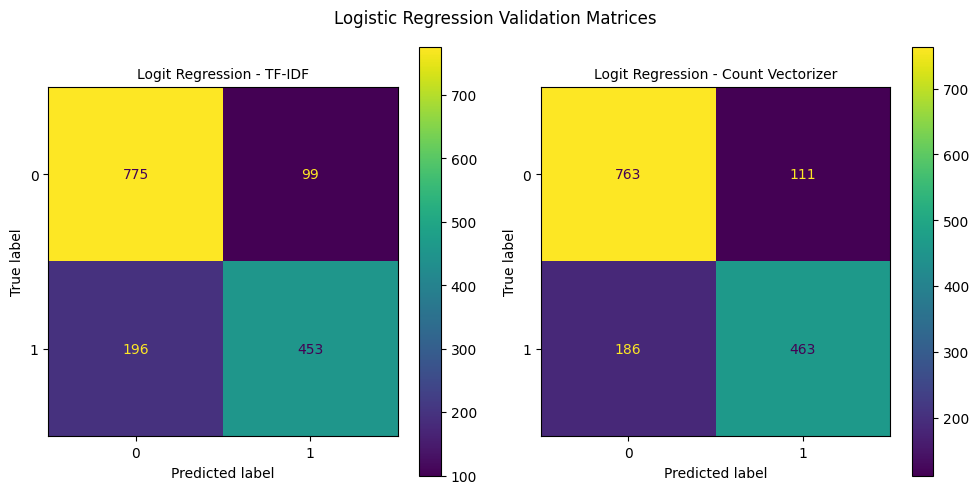

In [461]:
# Lets assess some of the values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Logistic Regression - TF-IDF & Count - VALIDATION
ax[0].set_title("Logit Regression - TF-IDF", size=10)
cm = confusion_matrix(y_val, y_pred_val_lr)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[0])

ax[1].set_title("Logit Regression - Count Vectorizer", size=10)
cm = confusion_matrix(y_val, y_pred_val_lr_cnt)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[1])

fig.suptitle("Logistic Regression Validation Matrices")

plt.tight_layout()

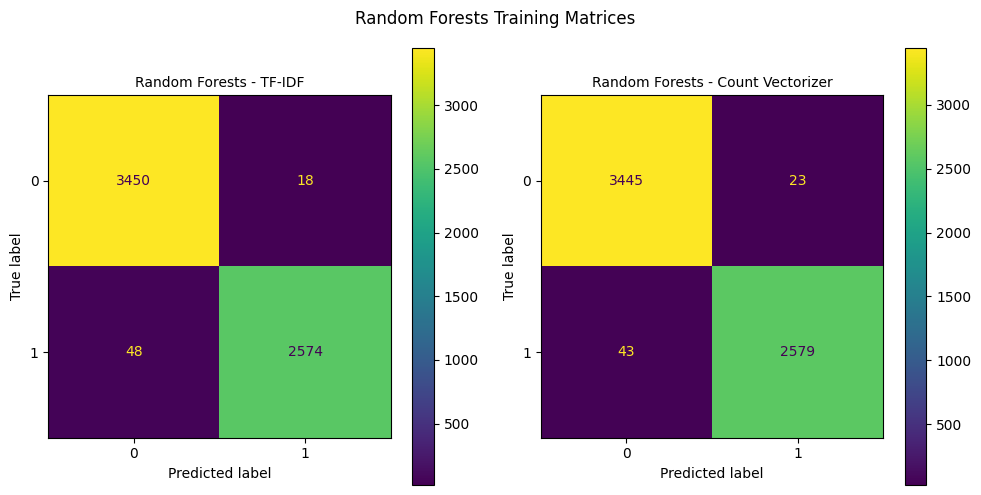

In [462]:
# Lets assess some of the values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Random Forests - TF-IDF & Count - TRAINING
ax[0].set_title("Random Forests - TF-IDF", size=10)
cm = confusion_matrix(y_train, y_pred_train_rf)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[0])

ax[1].set_title("Random Forests - Count Vectorizer", size=10)
cm = confusion_matrix(y_train, y_pred_train_rf_cnt)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[1])

fig.suptitle("Random Forests Training Matrices")

plt.tight_layout()

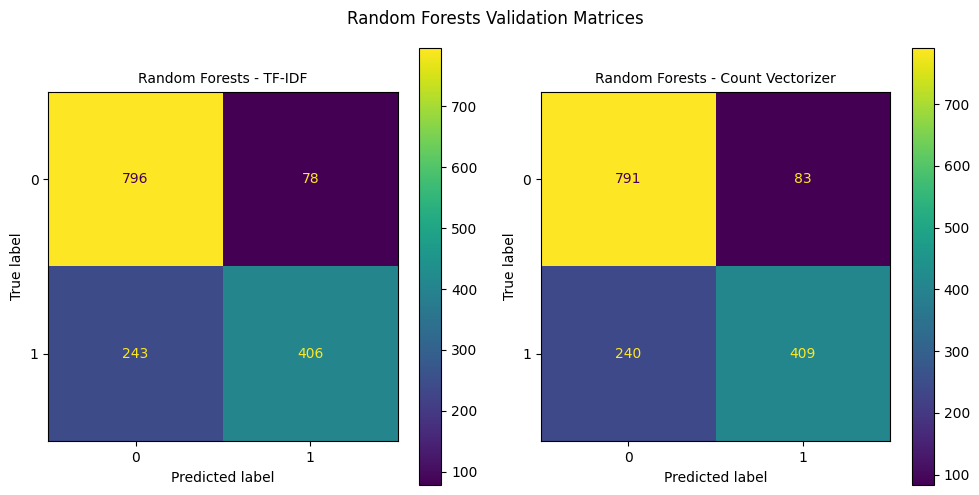

In [463]:
# Lets assess some of the values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Random Forests - TF-IDF & Count - Validation
ax[0].set_title("Random Forests - TF-IDF", size=10)
cm = confusion_matrix(y_val, y_pred_val_rf)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[0])

ax[1].set_title("Random Forests - Count Vectorizer", size=10)
cm = confusion_matrix(y_val, y_pred_val_rf_cnt)
cm_plt = ConfusionMatrixDisplay(cm, display_labels=logit_model.classes_)
cm_plt.plot(ax=ax[1])

fig.suptitle("Random Forests Validation Matrices")

plt.tight_layout()